<a href="https://colab.research.google.com/github/Ecevangelista/ML-422/blob/main/Assign3_1_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
!pip install eli5

     |████████████████████████████████| 106 kB 9.4 MB/s 


In [2]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import statistics
import numpy as np
from numpy import arange
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm,uniform
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, ElasticNet
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from eli5 import show_weights, explain_weights
from eli5.sklearn import explain_linear_regressor_weights

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "drive/MyDrive/422NU/housing_train.csv"
df_train = pd.read_csv(path)

In [5]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Preprocessing and Feature Engineering

In [6]:
df_trainc = df_train.copy(deep = True)

In [ ]:
#Convert ordinal variables with dictionary
Rating_dict = {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd" :4, "Ex" :5}

df_trainc['BsmtQual'] = df_trainc.BsmtQual.map(Rating_dict)
df_trainc['BsmtCond'] = df_trainc.BsmtCond.map(Rating_dict)
df_trainc['FireplaceQu'] = df_trainc.FireplaceQu.map(Rating_dict)
df_trainc['GarageQual'] = df_trainc.GarageQual.map(Rating_dict)
df_trainc['GarageCond'] = df_trainc.GarageCond.map(Rating_dict)
df_trainc['PoolQC'] = df_trainc.PoolQC.map(Rating_dict)
df_trainc['ExterQual'] = df_trainc.ExterQual.map(Rating_dict)
df_trainc['ExterCond'] = df_trainc.ExterCond.map(Rating_dict)
df_trainc['HeatingQC'] = df_trainc.HeatingQC.map(Rating_dict)
df_trainc['KitchenQual'] = df_trainc.KitchenQual.map(Rating_dict)

df_trainc.head(10)

In [8]:
#Fix NA in ordinal variables
df_trainc['BsmtQual'] = df_trainc['BsmtQual'].fillna(0)
df_trainc['BsmtCond'] = df_trainc['BsmtCond'].fillna(0)
df_trainc['FireplaceQu'] = df_trainc['FireplaceQu'].fillna(0)
df_trainc['GarageQual'] = df_trainc['GarageQual'].fillna(0)
df_trainc['GarageCond'] = df_trainc['GarageCond'].fillna(0)
df_trainc['PoolQC'] = df_trainc['PoolQC'].fillna(0)

df_trainc.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4.0,3.0,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0.0,Attchd,2003.0,RFn,2,548,3.0,3.0,Y,0,61,0,0,0,0,0.0,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4.0,3.0,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3.0,Attchd,1976.0,RFn,2,460,3.0,3.0,Y,298,0,0,0,0,0,0.0,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4.0,3.0,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3.0,Attchd,2001.0,RFn,2,608,3.0,3.0,Y,0,42,0,0,0,0,0.0,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3.0,4.0,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4.0,Detchd,1998.0,Unf,3,642,3.0,3.0,Y,0,35,272,0,0,0,0.0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4.0,3.0,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3.0,Attchd,2000.0,RFn,3,836,3.0,3.0,Y,192,84,0,0,0,0,0.0,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,Wood,4.0,3.0,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,3,5,Typ,0,0.0,Attchd,1993.0,Unf,2,480,3.0,3.0,Y,40,30,0,320,0,0,0.0,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,4,3,PConc,5.0,3.0,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,4,7,Typ,1,4.0,Attchd,2004.0,RFn,2,636,3.0,3.0,Y,255,57,0,0,0,0,0.0,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,3,3,CBlock,4.0,3.0,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,3,7,Typ,2,3.0,Attchd,1973.0,RFn,2,484,3.0,3.0,Y,235,204,228,0,0,0,0.0,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,3,3,BrkTil,3.0,3.0,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,3,8,Min1,2,3.0,Detchd,1931.0,Unf,2,468,2.0,3.0,Y,90,0,205,0,0,0,0.0,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,BrkTil,3.0,3.0,No,GLQ,85

In [9]:
#dropoutliers in trainc

df_trainc = df_trainc.drop(df_trainc[df_trainc['Id'] ==1299].index)
df_trainc = df_trainc.drop(df_trainc[df_trainc['Id'] == 524].index)

df_trainc.shape

(1458, 81)

In [10]:
#Add TotalSqftCalc
df_trainc['TotalSqftCalc'] = df_trainc['TotalBsmtSF'] + df_trainc['GrLivArea']
df_trainc.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqftCalc
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4.0,3.0,No,GLQ,706,Unf,0,150,856,GasA,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0.0,Attchd,2003.0,RFn,2,548,3.0,3.0,Y,0,61,0,0,0,0,0.0,NaN,NaN,0,2,2008,WD,Normal,208500,2566
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4.0,3.0,Gd,ALQ,978,Unf,0,284,1262,GasA,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3.0,Attchd,1976.0,RFn,2,460,3.0,3.0,Y,298,0,0,0,0,0,0.0,NaN,NaN,0,5,2007,WD,Normal,181500,2524
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4.0,3.0,Mn,GLQ,486,Unf,0,434,920,GasA,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3.0,Attchd,2001.0,RFn,2,608,3.0,3.0,Y,0,42,0,0,0,0,0.0,NaN,NaN,0,9,2008,WD,Normal,223500,2706
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3.0,4.0,No,ALQ,216,Unf,0,540,756,GasA,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4.0,Detchd,1998.0,Unf,3,642,3.0,3.0,Y,0,35,272,0,0,0,0.0,NaN,NaN,0,2,2006,WD,Abnorml,140000,2473
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4.0,3.0,Av,GLQ,655,Unf,0,490,1145,GasA,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3.0,Attchd,2000.0,RFn,3,836,3.0,3.0,Y,192,84,0,0,0,0,0.0,NaN,NaN,0,12,2008,WD,Normal,250000,3343


In [11]:
#Add Total BathroomsAbv & BathroomBelow

df_trainc['TotalBathAbv'] = df_trainc['FullBath'] + df_trainc['HalfBath']
df_trainc['TotalBathBelow'] = df_trainc['BsmtFullBath'] + df_trainc['BsmtHalfBath']

df_trainc.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqftCalc,TotalBathAbv,TotalBathBelow
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4.0,3.0,No,GLQ,706,Unf,0,150,856,GasA,...,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0.0,Attchd,2003.0,RFn,2,548,3.0,3.0,Y,0,61,0,0,0,0,0.0,NaN,NaN,0,2,2008,WD,Normal,208500,2566,3,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4.0,3.0,Gd,ALQ,978,Unf,0,284,1262,GasA,...,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3.0,Attchd,1976.0,RFn,2,460,3.0,3.0,Y,298,0,0,0,0,0,0.0,NaN,NaN,0,5,2007,WD,Normal,181500,2524,2,1
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4.0,3.0,Mn,GLQ,486,Unf,0,434,920,GasA,...,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3.0,Attchd,2001.0,RFn,2,608,3.0,3.0,Y,0,42,0,0,0,0,0.0,NaN,NaN,0,9,2008,WD,Normal,223500,2706,3,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3.0,4.0,No,ALQ,216,Unf,0,540,756,GasA,...,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4.0,Detchd,1998.0,Unf,3,642,3.0,3.0,Y,0,35,272,0,0,0,0.0,NaN,NaN,0,2,2006,WD,Abnorml,140000,2473,1,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4.0,3.0,Av,GLQ,655,Unf,0,490,1145,GasA,...,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3.0,Attchd,2000.0,RFn,3,836,3.0,3.0,Y,192,84,0,0,0,0,0.0,NaN,NaN,0,12,2008,WD,Normal,250000,3343,3,1



```

# Model 1 Ridge Regression

In [12]:
#Create new DF with smaller feature list based on removing features with high VIF

df_trainrid = df_trainc[['SalePrice', 'OverallQual', 'OverallCond', 'GarageArea', 'GarageCond', 'GarageType', 'GarageFinish', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr',
                         'KitchenQual', 'Fireplaces', 'FireplaceQu', 'TotalBathAbv', 'TotalBathBelow', 'ExterQual', 'MasVnrArea', 'MasVnrType', 'LotFrontage', 'LotArea', 'LotShape',
                         'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'MiscFeature', 'Fence', 'Neighborhood', 'BsmtCond', 'BsmtExposure', 'PoolQC',
                         'PoolArea','TotalSqftCalc', 'HeatingQC', 'HouseStyle', 'RoofStyle' ]]

In [13]:
df_trainrid.shape

(1458, 37)

In [14]:
#split into test and train
Xrid = df_trainrid.drop(columns = ['SalePrice'])
yrid = df_trainrid['SalePrice']


X_trainrid, X_testrid, y_trainrid, y_testrid = train_test_split(Xrid,yrid, test_size = 0.2, random_state = 10)

In [15]:
#Create lists for Numeric Features and Categorical Features to organize for Pipeline

num_featuresrid = ['OverallQual', 'OverallCond', 'GarageArea', 'GarageCond', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces','FireplaceQu', 'TotalBathAbv', 'TotalBathBelow', 
                    'ExterQual', 'MasVnrArea', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'BsmtCond', 'PoolQC', 'PoolArea','TotalSqftCalc',
                    'HeatingQC']

cat_featuresrid = ['GarageType', 'GarageFinish', 'MasVnrType', 'LotShape', 'MiscFeature', 'Fence', 'Neighborhood', 'BsmtExposure', 'HouseStyle', 'RoofStyle' ]

In [16]:
num_transformerrid = Pipeline(steps = [('imputer', SimpleImputer(strategy ='mean')), ('scale', MinMaxScaler())])

cat_transformerrid = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'constant')), ('one_hot_enc', OneHotEncoder(drop = 'first', handle_unknown = "ignore"))])

In [17]:
full_processorrid = ColumnTransformer(transformers =[('number', num_transformerrid, num_featuresrid), ('category', cat_transformerrid, cat_featuresrid)])

In [18]:
#Ridge Regression model
rid_set = Ridge(alpha = .5)

rid_pipe = Pipeline(steps = [('processor', full_processorrid), ('model', rid_set)]) 

modelrid = rid_pipe.fit(X_trainrid, y_trainrid)

In [19]:
#Models Ridge Regression TRAIN RMSE

modelridtrain_RMSE = mean_squared_error(y_trainrid, modelrid.predict(X_trainrid), squared = False)
print("Modelrid TRAIN RMSE", modelridtrain_RMSE)

Modelrid TRAIN RMSE 25268.822151047738


In [20]:
#Models Ridge Regression Test RMSE

modelridtest_RMSE = mean_squared_error(y_testrid, modelrid.predict(X_testrid), squared = False)
print("Modelrid Test RMSE", modelridtest_RMSE)

Modelrid Test RMSE 25984.312797577404


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


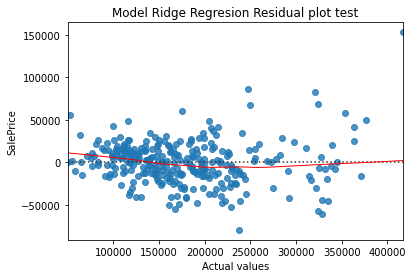

In [22]:
#Goodness of Fit tests
#ModelRID Test residualsplot
sns.residplot(x=modelrid.predict(X_testrid), y=y_testrid, lowess = True, 
              line_kws={'color':'red', 'lw' :1, 'alpha' :1})

plt.xlabel("Fitted values")
plt.xlabel("Actual values")
plt.title("Model Ridge Regresion Residual plot test")
plt.show()

In [21]:
#Calculating Ridge Regression predictions

modelrid_pred = modelrid.predict(X_testrid)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


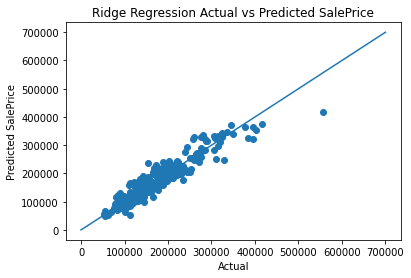

In [23]:
# RIDGE Actual vs Fitted

plt.scatter(y_testrid, modelrid_pred)
plt.plot(range(700000), range(700000))

plt.xlabel("Actual")
plt.ylabel("Predicted SalePrice")
plt.title("Ridge Regression Actual vs Predicted SalePrice")

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


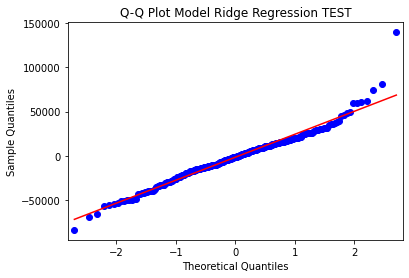

In [24]:
# Model qqplot Ridge test

modelrid_resid = y_testrid - (modelrid.predict(X_testrid))

sm.qqplot(modelrid_resid, line='s')
plt.title("Q-Q Plot Model Ridge Regression TEST")
plt.show()

In [25]:
#Use eli5 library to get weights from Ridge Regression Model

onehot_columnsrid = list(rid_pipe.named_steps['processor'].named_transformers_['category'].named_steps['one_hot_enc'].get_feature_names_out(input_features = cat_featuresrid))

numeric_features_listrid = list(num_featuresrid)
numeric_features_listrid.extend(onehot_columnsrid)

In [26]:
explain_weights(rid_pipe.named_steps['model'],top = 20,feature_names=numeric_features_listrid)

Weight?,Feature
+225864.114,TotalSqftCalc
+88584.521,OverallQual
+69604.204,LotArea
+64511.976,TotRmsAbvGrd
+63790.023,MasVnrArea
+52457.139,PoolQC
+42518.273,GarageArea
+41569.074,LotFrontage
+41476.965,Neighborhood_NoRidge
+39807.672,Neighborhood_StoneBr


# Model 2 LassoCV Regression

In [27]:
df_trainsmc = df_trainc[['SalePrice', 'OverallQual', 'OverallCond', 'GarageArea', 'GarageCond', 'GarageType', 'GarageFinish', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr',
                         'KitchenQual', 'Fireplaces', 'FireplaceQu', 'TotalBathAbv', 'TotalBathBelow', 'ExterQual', 'MasVnrArea', 'MasVnrType', 'LotFrontage', 'LotArea', 'LotShape',
                         'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'MiscFeature', 'Fence', 'Neighborhood', 'BsmtCond', 'BsmtExposure', 'PoolQC',
                         'PoolArea','TotalSqftCalc', 'HeatingQC', 'HouseStyle', 'RoofStyle' ]]

In [28]:
df_trainsmc.shape

(1458, 37)

In [29]:
#split into test and train
Xsmc = df_trainsmc.drop(columns = ['SalePrice'])
ysmc = df_trainsmc['SalePrice']


X_trainsmc, X_testsmc, y_trainsmc, y_testsmc = train_test_split(Xsmc,ysmc, test_size = 0.2, random_state = 10)

In [30]:
num_featuressmc = ['OverallQual', 'OverallCond', 'GarageArea', 'GarageCond', 'TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces','FireplaceQu', 'TotalBathAbv', 'TotalBathBelow', 
                    'ExterQual', 'MasVnrArea', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'BsmtCond', 'PoolQC', 'PoolArea','TotalSqftCalc',
                    'HeatingQC']

cat_featuressmc = ['GarageType', 'GarageFinish', 'MasVnrType', 'LotShape', 'MiscFeature', 'Fence', 'Neighborhood', 'BsmtExposure', 'HouseStyle', 'RoofStyle' ]

In [31]:
num_transformersmc = Pipeline(steps = [('impute', SimpleImputer(strategy ='mean')), ('scale', MinMaxScaler())])

cat_transformersmc = Pipeline(steps = [('impute', SimpleImputer(strategy = 'constant')), ('one_hot_enc', OneHotEncoder(drop = 'first', handle_unknown = "ignore"))])

In [32]:
full_processorsmc = ColumnTransformer(transformers =[('number', num_transformersmc, num_featuressmc), ('category', cat_transformersmc, cat_featuressmc)])

In [33]:
#LassoCV Regression
lassoCVsmc = LassoCV(cv=5, random_state= 8)

model_pipeCV = Pipeline(steps = [('processor', full_processorsmc), ('model', lassoCVsmc)]) 

modelCV = model_pipeCV.fit(X_trainsmc, y_trainsmc)

In [34]:
#Model LassoCV RMSE Train

modelCV_RMSE = mean_squared_error(y_trainsmc, modelCV.predict(X_trainsmc), squared = False)
print("Modelcv RMSE", modelCV_RMSE)

Modelcv RMSE 25733.966794039356


In [35]:
#Model LassoCV RMSE TEST

modelCV_RMSEtest = mean_squared_error(y_testsmc, modelCV.predict(X_testsmc), squared = False)
print("ModelCV RMSEtest", modelCV_RMSEtest)

ModelCV RMSEtest 25631.935174319337


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [36]:
#LassoCV Predictions

modelCV_pred = modelCV.predict(X_testsmc)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


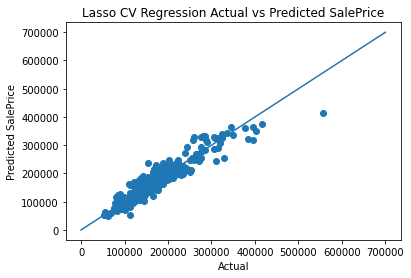

In [37]:
#LASSO CV GOODNESS OF FIT

# LASSOCV Actual vs Fitted

plt.scatter(y_testsmc, modelCV_pred)
plt.plot(range(700000), range(700000))

plt.xlabel("Actual")
plt.ylabel("Predicted SalePrice")
plt.title("Lasso CV Regression Actual vs Predicted SalePrice")

plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


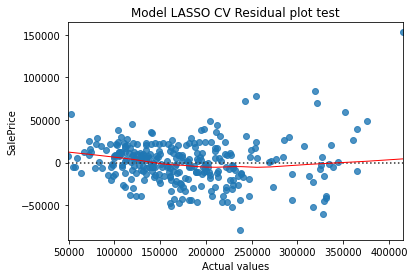

In [38]:
#Model LassoCV Residualsplot
sns.residplot(x=modelCV.predict(X_testsmc), y=y_testsmc, lowess = True, 
              line_kws={'color':'red', 'lw' :1, 'alpha' :1})

plt.xlabel("Fitted values")
plt.xlabel("Actual values")
plt.title("Model LASSO CV Residual plot test")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


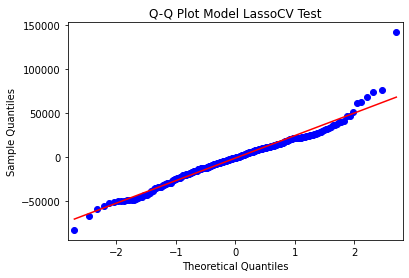

In [39]:
# Model LASSO CV qqplot

modelCV_resid = y_testsmc - (modelCV.predict(X_testsmc))

sm.qqplot(modelCV_resid, line='s')
plt.title("Q-Q Plot Model LassoCV Test")
plt.show()

In [40]:
#Use eli5 library to get weights from LassoCV Regression Model

onehot_columnscv = list(model_pipeCV.named_steps['processor'].named_transformers_['category'].named_steps['one_hot_enc'].get_feature_names_out(input_features = cat_featuressmc))

numeric_features_listcv = list(num_featuressmc)
numeric_features_listcv.extend(onehot_columnscv)

In [42]:
#LASSO CV SHOW WEIGHTS
explain_weights(model_pipeCV.named_steps['model'],top = 20,feature_names=numeric_features_listcv)

Weight?,Feature
+256148.305,TotalSqftCalc
+88911.892,OverallQual
+57201.282,MasVnrArea
+55680.421,LotArea
+55539.528,PoolQC
+39573.239,GarageArea
+38534.138,TotRmsAbvGrd
+38106.125,Neighborhood_NoRidge
+36494.054,OverallCond
+34267.490,LotFrontage


# Model 3 Elastic Net Regression with default alpha and L1 Ratio

In [43]:
#Model3 Elastic Net Regression with default values

EN_set = ElasticNet(alpha = 1, l1_ratio = 0.5)

EN_pipe = Pipeline(steps = [('processor', full_processorrid), ('model', EN_set)]) 

modelEN = EN_pipe.fit(X_trainrid, y_trainrid)

In [44]:
#Models Elastic Net default TRAIN RMSE

modelENtrain_RMSE = mean_squared_error(y_trainrid, modelEN.predict(X_trainrid), squared = False)
print("ModelEN TRAIN RMSE", modelENtrain_RMSE)

ModelEN TRAIN RMSE 54856.78180283479


In [45]:
#Model Elastic Net default TEST RMSE

modelENtest_RMSE = mean_squared_error(y_testrid, modelEN.predict(X_testrid), squared = False)
print("ModelEN Test RMSE", modelENtest_RMSE)

ModelEN Test RMSE 47620.64619484194


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


In [47]:
#Elastic Net default predictions

modelEN_pred = modelEN.predict(X_testrid)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4, 6] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


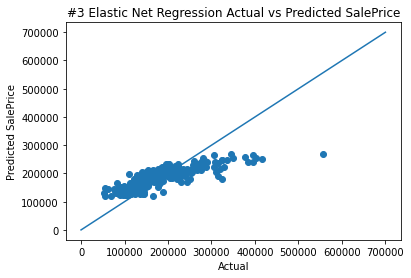

In [48]:
#Elastic Net default Goodness of Fit
#Actual vs. Fitted SalePrice

plt.scatter(y_testrid, modelEN_pred)
plt.plot(range(700000), range(700000))

plt.xlabel("Actual")
plt.ylabel("Predicted SalePrice")
plt.title("#3 Elastic Net Regression Actual vs Predicted SalePrice")

plt.show()

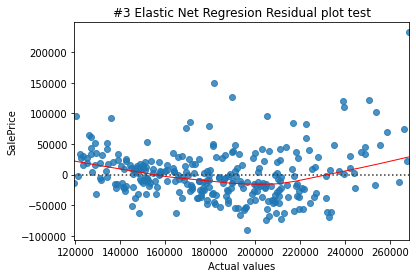

In [49]:
#Model Elastic Net Default Test residualsplot
sns.residplot(x=modelEN_pred, y=y_testrid, lowess = True, 
              line_kws={'color':'red', 'lw' :1, 'alpha' :1})

plt.xlabel("Fitted values")
plt.xlabel("Actual values")
plt.title("#3 Elastic Net Regresion Residual plot test")
plt.show()

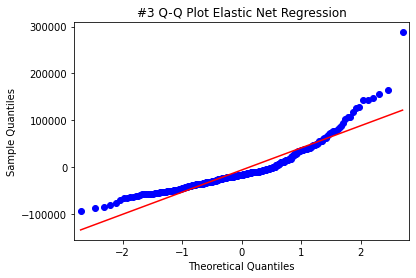

In [50]:
# QQplot Elastic Net default test

modelEN_resid = y_testrid - modelEN_pred

sm.qqplot(modelEN_resid, line='s')
plt.title("#3 Q-Q Plot Elastic Net Regression")
plt.show()

In [51]:
#Use eli5 library to get weights from Elastic Net default Regression Model

onehot_columnsEN2 = list(EN_pipe.named_steps['processor'].named_transformers_['category'].named_steps['one_hot_enc'].get_feature_names_out(input_features = cat_featuresrid))

numeric_features_listrid = list(num_featuresrid)
numeric_features_listrid.extend(onehot_columnsEN2)

In [52]:
#SHOW WEIGHTS
explain_weights(EN_pipe.named_steps['model'], top = 20, feature_names=numeric_features_listrid)

Weight?,Feature
+146698.782,<BIAS>
+14014.136,FireplaceQu
+12892.960,KitchenQual
+11510.658,ExterQual
+10956.789,OverallQual
+10614.928,HeatingQC
+9952.636,TotalSqftCalc
+9331.824,TotalBathAbv
+8960.707,BsmtExposure_Gd
+8773.715,GarageArea


# Model 4 Elastic Net Regression with Tuned Hyperparameters

In [53]:
# Elastic Net Tuning Hyperparameters
foldsEN = KFold(n_splits = 5, shuffle = True, random_state = 10)

ENG_set = ElasticNet()

EN_pipe = Pipeline(steps = [('processor', full_processorrid), ('model', ENG_set)]) 

gridENG = dict()
gridENG['model__alpha'] = [0, 0.1, 0.5, 0.7, 0.9, 1.0, 0.01, 0.001]
gridENG['model__l1_ratio'] = arange(0,1,0.1)

searchENG = GridSearchCV(EN_pipe, gridENG, scoring = 'neg_root_mean_squared_error', cv = foldsEN )
resultsENG = searchENG.fit(X_trainrid, y_trainrid)

print('RMSE: %.5f' % resultsENG.best_score_)
print('config: %s' % resultsENG.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e+11, tolerance: 6.120e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coe

RMSE: -28475.16549
config: {'model__alpha': 0.001, 'model__l1_ratio': 0.2}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.844e+11, tolerance: 6.118e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [54]:
#ElasticNet on TEST using Best Parameters from Training

EN_test = ElasticNet(alpha = 0.001, l1_ratio = 0.2)

ENtest_pipe = Pipeline(steps = [('processor', full_processorrid), ('model', EN_test)]) 

modelENtest = ENtest_pipe.fit(X_testrid, y_testrid)

In [55]:
#Model 4 ElasticNet TEST RMSE - TUNED HYPERPARAMETER


modelENtest1_RMSE = mean_squared_error(y_testrid, modelENtest.predict(X_testrid), squared = False)
print("ModelEN Test TUNED1 RMSE", modelENtest1_RMSE)

ModelEN Test TUNED1 RMSE 21638.708914127597


In [56]:
#Model 4 ElasticNet predictions

modelENtest1_pred = modelENtest.predict(X_testrid)

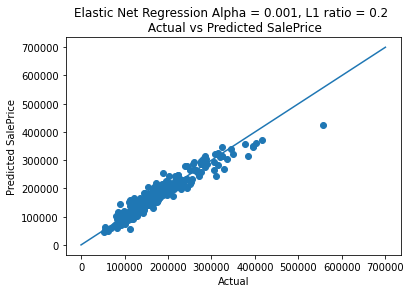

In [57]:
#Goodness of Fit 

plt.scatter(y_testrid, modelENtest1_pred)
plt.plot(range(700000), range(700000))

plt.xlabel("Actual")
plt.ylabel("Predicted SalePrice")
plt.title("Elastic Net Regression Alpha = 0.001, L1 ratio = 0.2 \n Actual vs Predicted SalePrice")

plt.show()


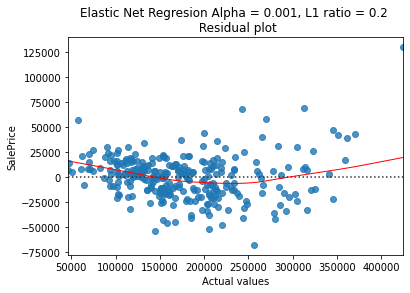

In [58]:
#Model 4 ElasticNet Test TUNED2 residualsplot
sns.residplot(x=modelENtest1_pred, y=y_testrid, lowess = True, 
              line_kws={'color':'red', 'lw' :1, 'alpha' :1})

plt.xlabel("Fitted values")
plt.xlabel("Actual values")
plt.title("Elastic Net Regresion Alpha = 0.001, L1 ratio = 0.2 \n Residual plot")
plt.show()

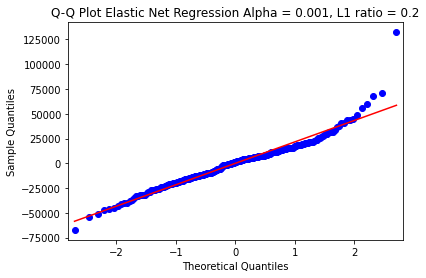

In [59]:
# Model 4 ElasticNet QQ plot 

modelENtest_resid = y_testrid - modelENtest1_pred

sm.qqplot(modelENtest_resid, line='s')
plt.title("Q-Q Plot Elastic Net Regression Alpha = 0.001, L1 ratio = 0.2")
plt.show()

In [60]:
#Use eli5 library to get weights from Model 4 Elastic Net default Regression Model

onehot_columnsEN = list(ENtest_pipe.named_steps['processor'].named_transformers_['category'].named_steps['one_hot_enc'].get_feature_names_out(input_features = cat_featuresrid))

numeric_features_listrid = list(num_featuresrid)
numeric_features_listrid.extend(onehot_columnsEN)

In [61]:
#SHOW WEIGHTS
explain_weights(ENtest_pipe.named_steps['model'],top = 20,feature_names=numeric_features_listrid)

Weight?,Feature
+142521.299,TotalSqftCalc
+62787.396,Neighborhood_StoneBr
+54593.410,OverallQual
+42787.344,LotArea
+42578.003,Neighborhood_NridgHt
+39232.966,OverallCond
+37793.160,GarageType_BuiltIn
+37646.912,GarageArea
+34819.887,KitchenQual
+31519.151,GarageType_Attchd
